# Image Classification

## Task description
The task is to train an already pretrained Convolutional Neural Network architecture on a dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
!pip install wget
!pip install torch
!pip install torchvision
!pip install Pillow scipy

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=30e34abaa0bfdd0b1e969d729346a33e6290dd81d294e1d9f833b107d44ed5c6
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import zipfile
import tarfile
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_zip_path = "/content/drive/MyDrive/Cars196/cars_train.tgz.zip"
test_zip_path = "/content/drive/MyDrive/Cars196/cars_test.tgz.zip"
devkit_path = "/content/drive/MyDrive/Cars196/car_devkit.tgz"

os.makedirs('/content/train', exist_ok=True)
os.makedirs('/content/test', exist_ok=True)
os.makedirs('/content/devkit', exist_ok=True)
os.makedirs('/content/Cars196', exist_ok=True)

In [5]:
train_tgz_path = "/content/Cars196/cars_train.tgz"
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Cars196')

with tarfile.open(train_tgz_path, 'r:gz') as tar_ref:
    tar_ref.extractall('/content/train')

# Unzip and extract the test dataset
test_tgz_path = "/content/Cars196/cars_test.tgz"
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Cars196')

with tarfile.open(test_tgz_path, 'r:gz') as tar_ref:
    tar_ref.extractall('/content/test')

# Extract the devkit dataset
with tarfile.open(devkit_path, 'r:gz') as tar_ref:
    tar_ref.extractall('/content/devkit')

print("All files have been successfully extracted.")

All files have been successfully extracted.


#### Loading the dataset
Show some images and labels of your dataset

In [6]:
def load_car_data():
    car_meta = loadmat('/content/devkit/devkit/cars_meta.mat')['class_names'][0]
    train_labels = loadmat('/content/devkit/devkit/cars_train_annos.mat')['annotations'][0]
    test_labels = loadmat('/content/devkit/devkit/cars_test_annos.mat')['annotations'][0]

    return car_meta, train_labels, test_labels

car_meta, train_labels, test_labels = load_car_data()

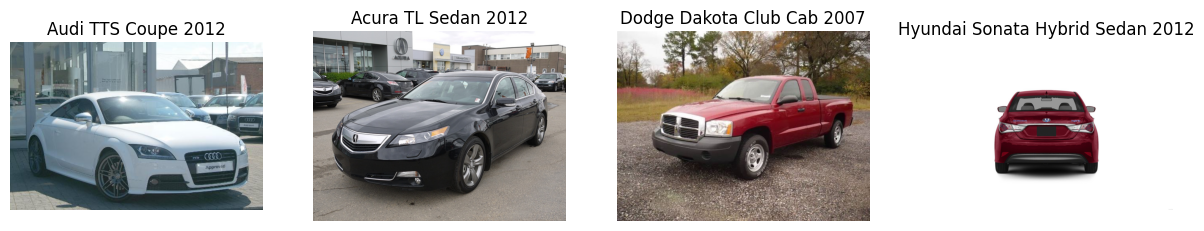

In [7]:
def show_some_images(images, labels, car_meta):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, (image, label) in enumerate(zip(images, labels)):
        axes[idx].imshow(image)
        axes[idx].set_title(car_meta[label - 1][0])
        axes[idx].axis('off')
    plt.show()

images = [Image.open(f'/content/train/cars_train/{train_labels[i][5][0]}') for i in range(4)]
labels = [train_labels[i][4][0][0] for i in range(4)]

show_some_images(images, labels, car_meta)

#### Splitting the dataset

In [8]:
train_labels, val_labels = train_test_split(train_labels, test_size=0.2, random_state=42)

#### Pre-processing the dataset

In [9]:
class CarDataset(Dataset):
    def __init__(self, labels, root_dir, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels[idx][5][0])
        image = Image.open(img_name)
        label = self.labels[idx][4][0][0] - 1

        if self.transform:
            image = self.transform(image)

        return image, label

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Ensure 3-channel image
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Ensure 3-channel image
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Ensure 3-channel image
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = CarDataset(train_labels, '/content/train/cars_train', transform=data_transforms['train'])
val_dataset = CarDataset(val_labels, '/content/train/cars_train', transform=data_transforms['val'])
test_dataset = CarDataset(test_labels, '/content/test/cars_test', transform=data_transforms['test'])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
}

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [10]:
!export CUDA_LAUNCH_BLOCKING=1
from torchvision.models.vgg import VGG16_Weights

num_classes = len(car_meta)

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.7MB/s]


#### Define your optimizer and loss function

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
import torch

if torch.cuda.is_available():
    print(f"Using {torch.cuda.get_device_name()}")

    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.memory_allocated(i)/1024**2:.2f} MB allocated")

Using Tesla T4
Device 0: 516.10 MB allocated


#### Train your network

In [13]:
import time
import copy


def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Add lists to store loss and accuracy history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save loss and accuracy values to history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return model and history
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [14]:
trained_model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25)

Epoch 0/24
----------
train Loss: 5.1447 Acc: 0.0183
val Loss: 4.5023 Acc: 0.0583

Epoch 1/24
----------
train Loss: 4.3973 Acc: 0.0746
val Loss: 3.5285 Acc: 0.1774

Epoch 2/24
----------
train Loss: 3.7199 Acc: 0.1569
val Loss: 2.8572 Acc: 0.2793

Epoch 3/24
----------
train Loss: 3.2513 Acc: 0.2362
val Loss: 2.4073 Acc: 0.3726

Epoch 4/24
----------
train Loss: 2.9041 Acc: 0.2890
val Loss: 1.9585 Acc: 0.4653

Epoch 5/24
----------
train Loss: 2.6168 Acc: 0.3493
val Loss: 1.7657 Acc: 0.5144

Epoch 6/24
----------
train Loss: 2.3615 Acc: 0.4071
val Loss: 1.6625 Acc: 0.5445

Epoch 7/24
----------
train Loss: 1.8960 Acc: 0.5122
val Loss: 1.2194 Acc: 0.6611

Epoch 8/24
----------
train Loss: 1.7418 Acc: 0.5432
val Loss: 1.1493 Acc: 0.6716

Epoch 9/24
----------
train Loss: 1.7128 Acc: 0.5460
val Loss: 1.1176 Acc: 0.6882

Epoch 10/24
----------
train Loss: 1.6812 Acc: 0.5639
val Loss: 1.0850 Acc: 0.6900

Epoch 11/24
----------
train Loss: 1.6495 Acc: 0.5662
val Loss: 1.0817 Acc: 0.6992

Ep

#### Show results (accuracy and loss) on training and validation sets

In [15]:
torch.save(trained_model.state_dict(), '/content/model')

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

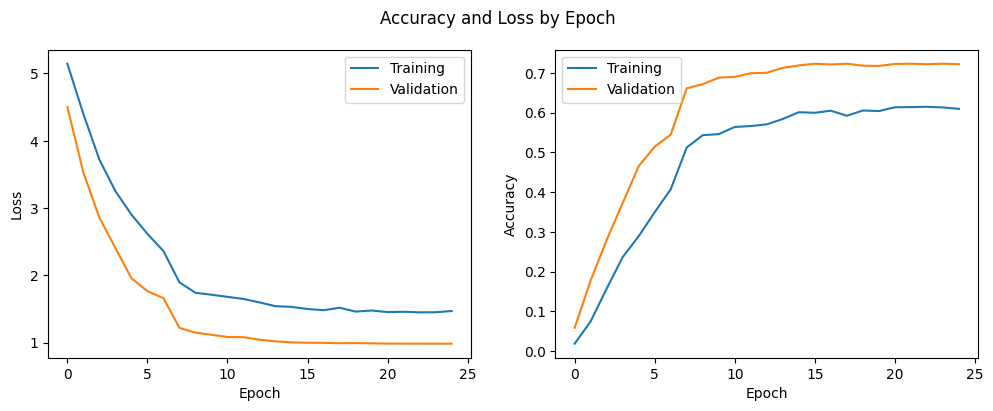

In [16]:
import matplotlib.pyplot as plt
import torch

# Define the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Accuracy and Loss by Epoch')

# Plot the training and validation loss history
axs[0].plot(torch.Tensor(train_loss_history).cpu(), label='Training')
axs[0].plot(torch.Tensor(val_loss_history).cpu(), label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation accuracy history
axs[1].plot(torch.Tensor(train_acc_history).cpu(), label='Training')
axs[1].plot(torch.Tensor(val_acc_history).cpu(), label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Show the plot
plt.show()

#### Show some predictions

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

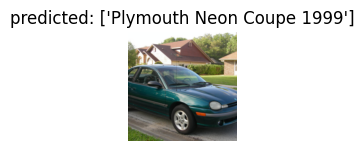

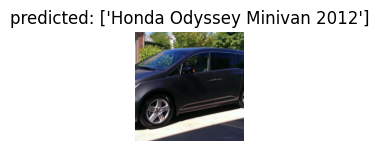

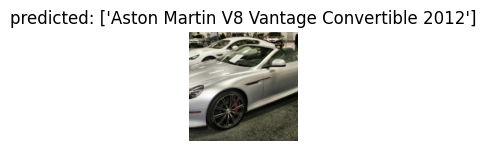

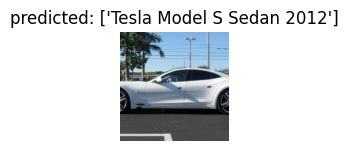

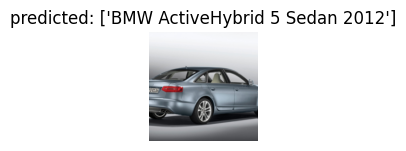

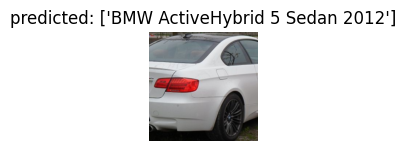

In [18]:
def visualize_model(model, dataloader, device, class_names, num_images=6):
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

visualize_model(trained_model, dataloaders['val'], device, car_meta)
plt.ioff()
plt.show()

#### Answer the questions

The results look promising with a maximum validation accuracy of 72.31%. The training and validation losses are decreasing consistenly over the epochs, which indicates that the model is learning and improving its perfomance. There is also a small difference in training and validation accuracy which means it is not largely overfitting. Overall, the results are good, but some further fine-tuning of the model may improve the performance.

Citation:

       3D Object Representations for Fine-Grained Categorization
       Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
       4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.
       [pdf]   [BibTex]   [slides]
